In [9]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import json 

from gensim.parsing.preprocessing import STOPWORDS


In [5]:
STOPWORDS = set(STOPWORDS)

In [11]:
def remove_username(tweet):
    p = re.compile(ur'(@[A-Za-z0-9_-]+)', re.MULTILINE | re.IGNORECASE)
    return re.sub(p, ' ', tweet)
def remove_hashtag(tweet):
    p = re.compile(ur'(#[A-Za-z0-9_-]+)', re.MULTILINE | re.IGNORECASE)
    return re.sub(p, ' ', tweet)

def preprocess(tweet):
    tweet = tweet.lower()
    tweet = remove_username(tweet)
    tweet = remove_hashtag(tweet)
    tweet = re.sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", " ", tweet)
    tweet = re.sub(ur"\s+"," ", tweet)
    tweet = tweet.split()
    tweet = [a for a in tweet if a not in STOPWORDS]
    return tweet
    

In [10]:
data = json.load(open('../Data/gnip_sample2m.json'))
print "'The length of data is {}".format(len(data))
### Extract the twitter text from the lists of data
text = [item[u'twitter_text'] for item in data]

'The length of data is 2027707


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 stop_words='english',
                                 use_idf=True, tokenizer=preprocess, ngram_range=(1,2))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(text) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 2min 29s, sys: 2.89 s, total: 2min 32s
Wall time: 2min 31s
(2027707, 200000)


In [18]:
from sklearn.cluster import KMeans

num_clusters = 100

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 5h 9min 4s, sys: 10min 28s, total: 5h 19min 32s
Wall time: 5h 15min 33s


In [19]:
import cPickle
cPickle.dump(km , open('kmean_2m_tweets.pkl' , 'wb') , protocol = 2)

In [48]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    cluster_words = order_centroids[i, :11]
    words = [tfidf_idx2vocab[_] for _ in cluster_words]
    
    print ("Cluster {} , {}".format(i, words))
    print ()
    
    

Top terms per cluster:

Cluster 0 words:Cluster 0 , [u'cancer', u'ovarian', u'signs', u'silent', u'ovarian cancer', u'... cancer', u'signs ""the', u'""the silent', u'silent killer""', u'killer""', u'""the']

Cluster 1 words:Cluster 1 , [u"wendy's", u": wendy's", u'4', u"wendy's ?", u':', u'rt', u'?', u'rt :', u"want wendy's", u'4 4', u'want']

Cluster 2 words:Cluster 2 , [u'rt', u'rt :', u':', u': ?', u'?', u'https:?', u': :', u'http?', u'htt?', u'https?', u': rt']

Cluster 3 words:Cluster 3 , [u'word', u'create word', u'. word', u'word is.', u'protip :', u': protip', u'protip', u'called racism.', u'need create', u'word .', u"didn't need"]

Cluster 4 words:Cluster 4 , [u'hug', u'?', u'about. ?', u'care about.', u'? listen', u'tree.', u'friend. ?', u'more. ?', u': ways', u'depression', u'about.']

Cluster 5 words:Cluster 5 , [u'ns-15t8lte 8gb', u'8"" ns-15t8lte', u'ns-15t8lte', u'flex 8""', u'8gb wi-fi', u'verizon android', u'4g verizon', u'8""', u'flex', u'insignia flex', u'insignia']


In [52]:
km.predict(tfidf_vectorizer.transform(preprocess('i support trump')))

array([61, 58], dtype=int32)

In [31]:
tfidf_idx2vocab = {v:k for k,v in tfidf_vectorizer.vocabulary_.iteritems()}

In [108]:
#### Get cluster labels which are 0

tweet_index = {}
cluster_index = []
for i in xrange(5):
    a = np.where(km.labels_ == i)
    clusters_list = a[0][:30].tolist()
    print ("count of cluster {} is {}".format(i, len(clusters_list)))
    cluster_index.extend(clusters_list)
    tweet_index[i] = clusters_list


count of cluster 0 is 30
count of cluster 1 is 30
count of cluster 2 is 30
count of cluster 3 is 30
count of cluster 4 is 1


In [98]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix[cluster_index])
print
print

<function print>

In [99]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()


In [100]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=km.labels_[cluster_index], title=cluster_index)) 

#group by cluster
groups = df.groupby('label')

In [101]:


#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict

cluster_names = {}
for i in range(5):
    print("Cluster %d words:" % i, end='')
    
    cluster_words = order_centroids[i, :5]
    words = [tfidf_idx2vocab[_] for _ in cluster_words]
    cluster_names[i] = str(words)


Cluster 0 words:Cluster 1 words:Cluster 2 words:Cluster 3 words:Cluster 4 words:

In [109]:
cluster_names

{0: "[u'cancer', u'ovarian', u'signs', u'silent', u'ovarian cancer']",
 1: '[u"wendy\'s", u": wendy\'s", u\'4\', u"wendy\'s ?", u\':\']',
 2: "[u'rt', u'rt :', u':', u': ?', u'?']",
 3: "[u'word', u'create word', u'. word', u'word is.', u'protip :']",
 4: "[u'hug', u'?', u'about. ?', u'care about.', u'? listen']"}

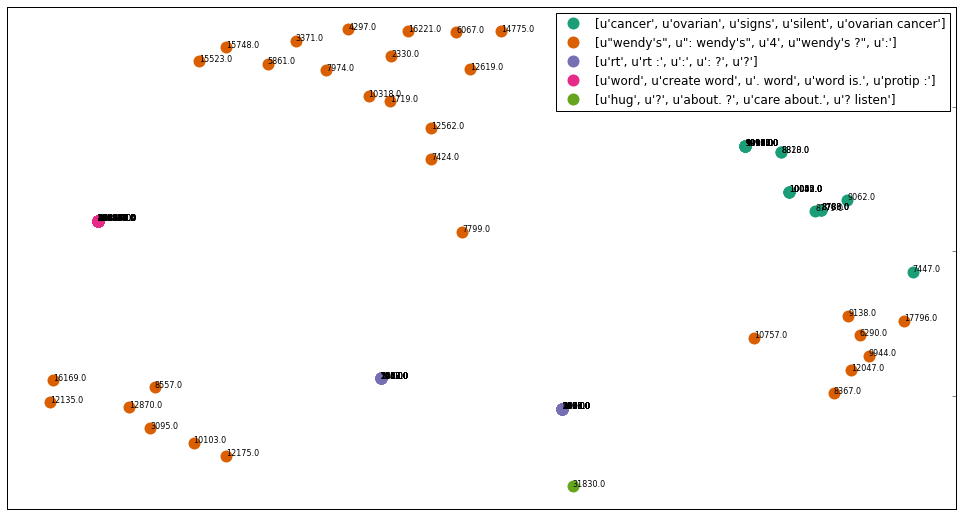

In [103]:
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plo

In [111]:
###### Top Tweets in cluseter 2

for i in tweet_index[2]:
    print (text[i])
    print ()


RT @TheRealFrankC_: #BlackLivesMatter #TerenceCrutcher

RT @RealJamesWoods: https://t.co/zq5PRASZLv

RT @cubasteve57: @Bertieschip @oliveri_pablo @11_Porsche @cubasteve57 https://t.co/vgWAW2GwxI

RT @FucoidanForce: #mondaymotivation #fitness #supplements #rightchoice #healthyliving #health #healthy? https://t.co/UY4mWuqBW3

RT @FucoidanForce: #mondaymotivation #fitness #supplements #rightchoice #healthyliving #health #healthy? https://t.co/UY4mWuqBW3

RT @Trump_World: #Trump #Trump2016 #TrumpTrain https://t.co/1OgNrHYIXo

RT @FucoidanForce: #mondaymotivation #fitness #supplements #rightchoice #healthyliving #health #healthy? https://t.co/UY4mWuqBW3

RT @FucoidanForce: #mondaymotivation #fitness #supplements #rightchoice #healthyliving #health #healthy? https://t.co/UY4mWuqBW3

RT @DSA_ChrisH: @DSA_Airport @AmiraElkhrouf @DSACargoDayle @angloworldcargo https://t.co/JmwAio9JIQ

RT @FucoidanForce: #mondaymotivation #fitness #supplements #rightchoice #healthyliving #health #healthy? https:

In [112]:
###### Top Tweets in cluseter 0

for i in tweet_index[0]:
    print (text[i])
    print ()


Cancer

"RT @FunnyBrawlss: Early Signs Of ""The Silent Killer"" Ovarian Cancer. https://t.co/iMusD5esmT"

"RT @FunnyBrawlss: Early Signs Of ""The Silent Killer"" Ovarian Cancer. https://t.co/iMusD5esmT"

"RT @FunnyBrawlss: Early Signs Of ""The Silent Killer"" Ovarian Cancer. https://t.co/iMusD5esmT"

"RT @FunnyBrawlss: Early Signs Of ""The Silent Killer"" Ovarian Cancer. https://t.co/iMusD5esmT"

"RT @FunnyBrawlss: Overlooked Warning Signs of ""The Silent Killer"" - Ovarian Cancer. https://t.co/iMusD5esmT"

"RT @FunnyBrawlss: Overlooked Warning Signs of ""The Silent Killer"" - Ovarian Cancer. https://t.co/iMusD5esmT"

"Early Signs Of ""The Silent Killer"" Ovarian Cancer. https://t.co/iMusD5esmT"

Cancer Pain https://t.co/Hbe46yms5c

Cancer Pain https://t.co/kb2gSjipyv

"RT @FunnyBrawlss: Overlooked Warning Signs of ""The Silent Killer"" - Ovarian Cancer https://t.co/iMusD5esmT"

"RT @FunnyBrawlss: Overlooked Warning Signs of ""The Silent Killer"" - Ovarian Cancer https://t.co/iMusD5esm